Dataset shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First 5 rows:
=== Dataset Information ===
Total records: 284,807
Number of features: 31
Memory usage: 67.36 MB
=== Missing Values ===
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
Duplicate rows: 1081
=== Target Variable Distribution ===
        Count  Percentage
Class                    
0      284315   99.827251
1         492    0.172749


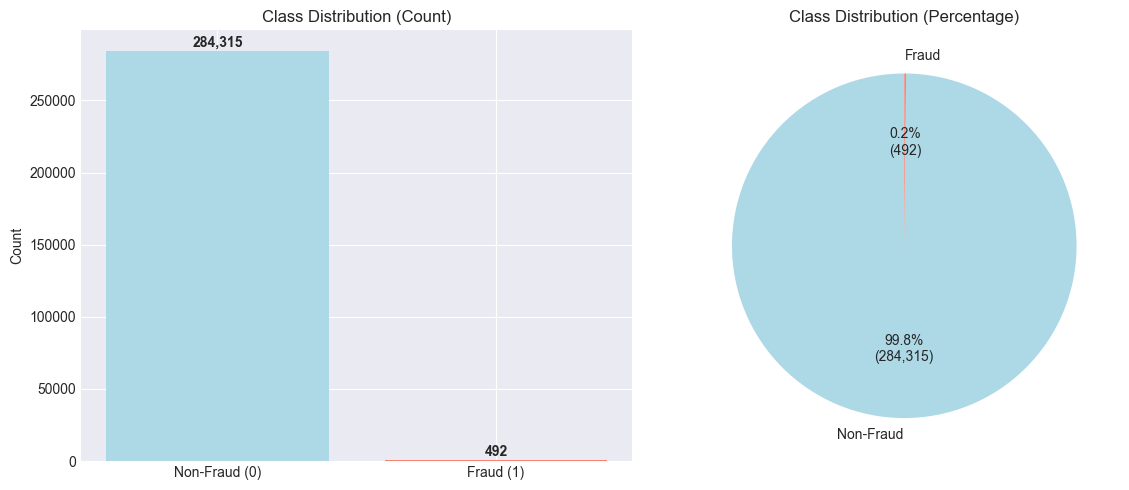

=== Time and Amount Analysis ===
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
25%     54201.500000       5.600000
50%     84692.000000      22.000000
75%    139320.500000      77.165000
max    172792.000000   25691.160000


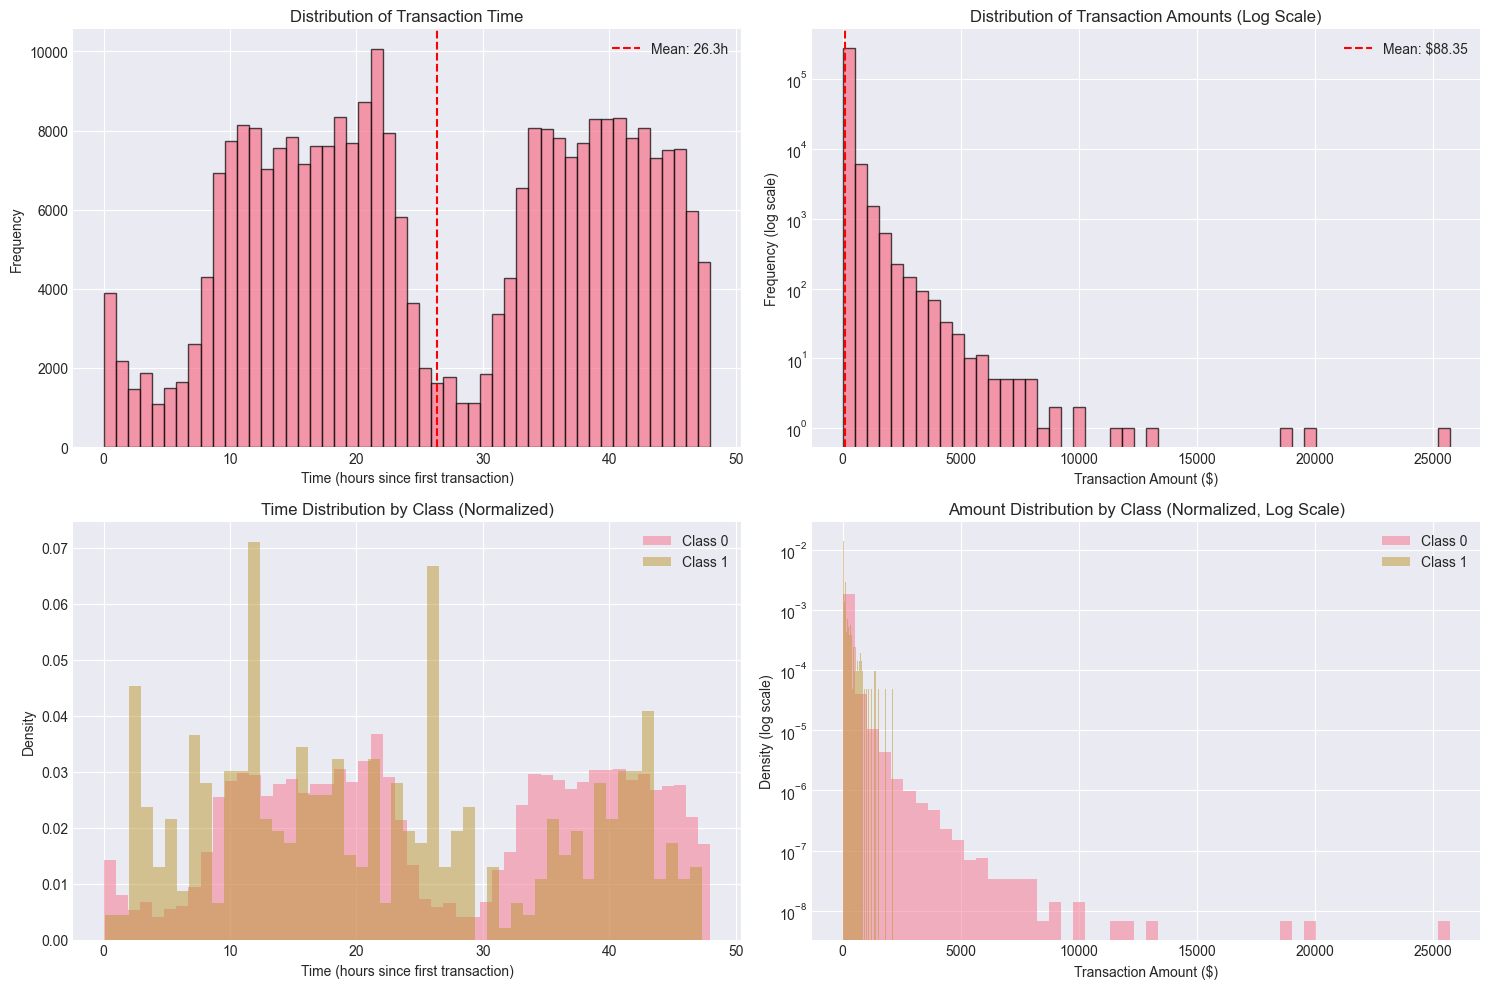

=== PCA Components Analysis ===
             Mean       Std         Min         Max
V1   1.168375e-15  1.958696  -56.407510    2.454930
V2   3.416908e-16  1.651309  -72.715728   22.057729
V3  -1.379537e-15  1.516255  -48.325589    9.382558
V4   2.074095e-15  1.415869   -5.683171   16.875344
V5   9.604066e-16  1.380247 -113.743307   34.801666
V6   1.487313e-15  1.332271  -26.160506   73.301626
V7  -5.556467e-16  1.237094  -43.557242  120.589494
V8   1.213481e-16  1.194353  -73.216718   20.007208
V9  -2.406331e-15  1.098632  -13.434066   15.594995
V10  2.239053e-15  1.088850  -24.588262   23.745136


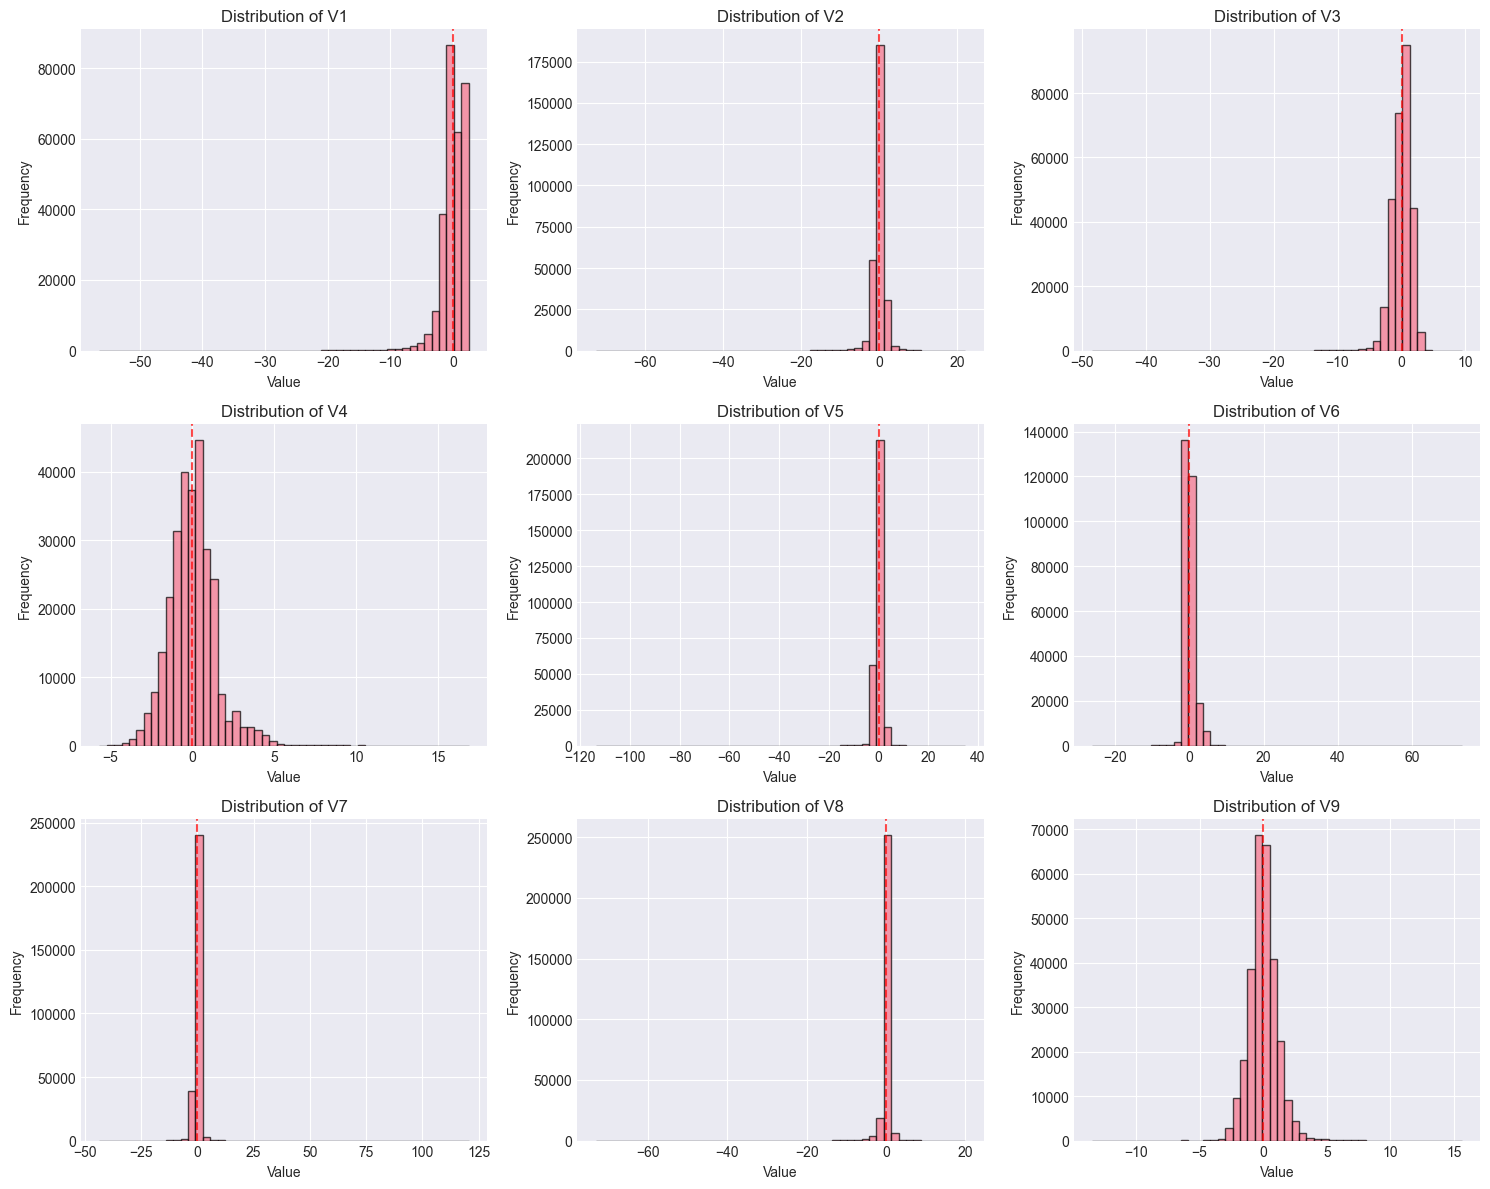

=== Correlation with Target ===
Top 10 features most correlated with fraud:
   Feature  Correlation
16     V17    -0.326481
13     V14    -0.302544
11     V12    -0.260593
9      V10    -0.216883
15     V16    -0.196539
2       V3    -0.192961
6       V7    -0.187257
10     V11     0.154876
3       V4     0.133447
17     V18    -0.111485


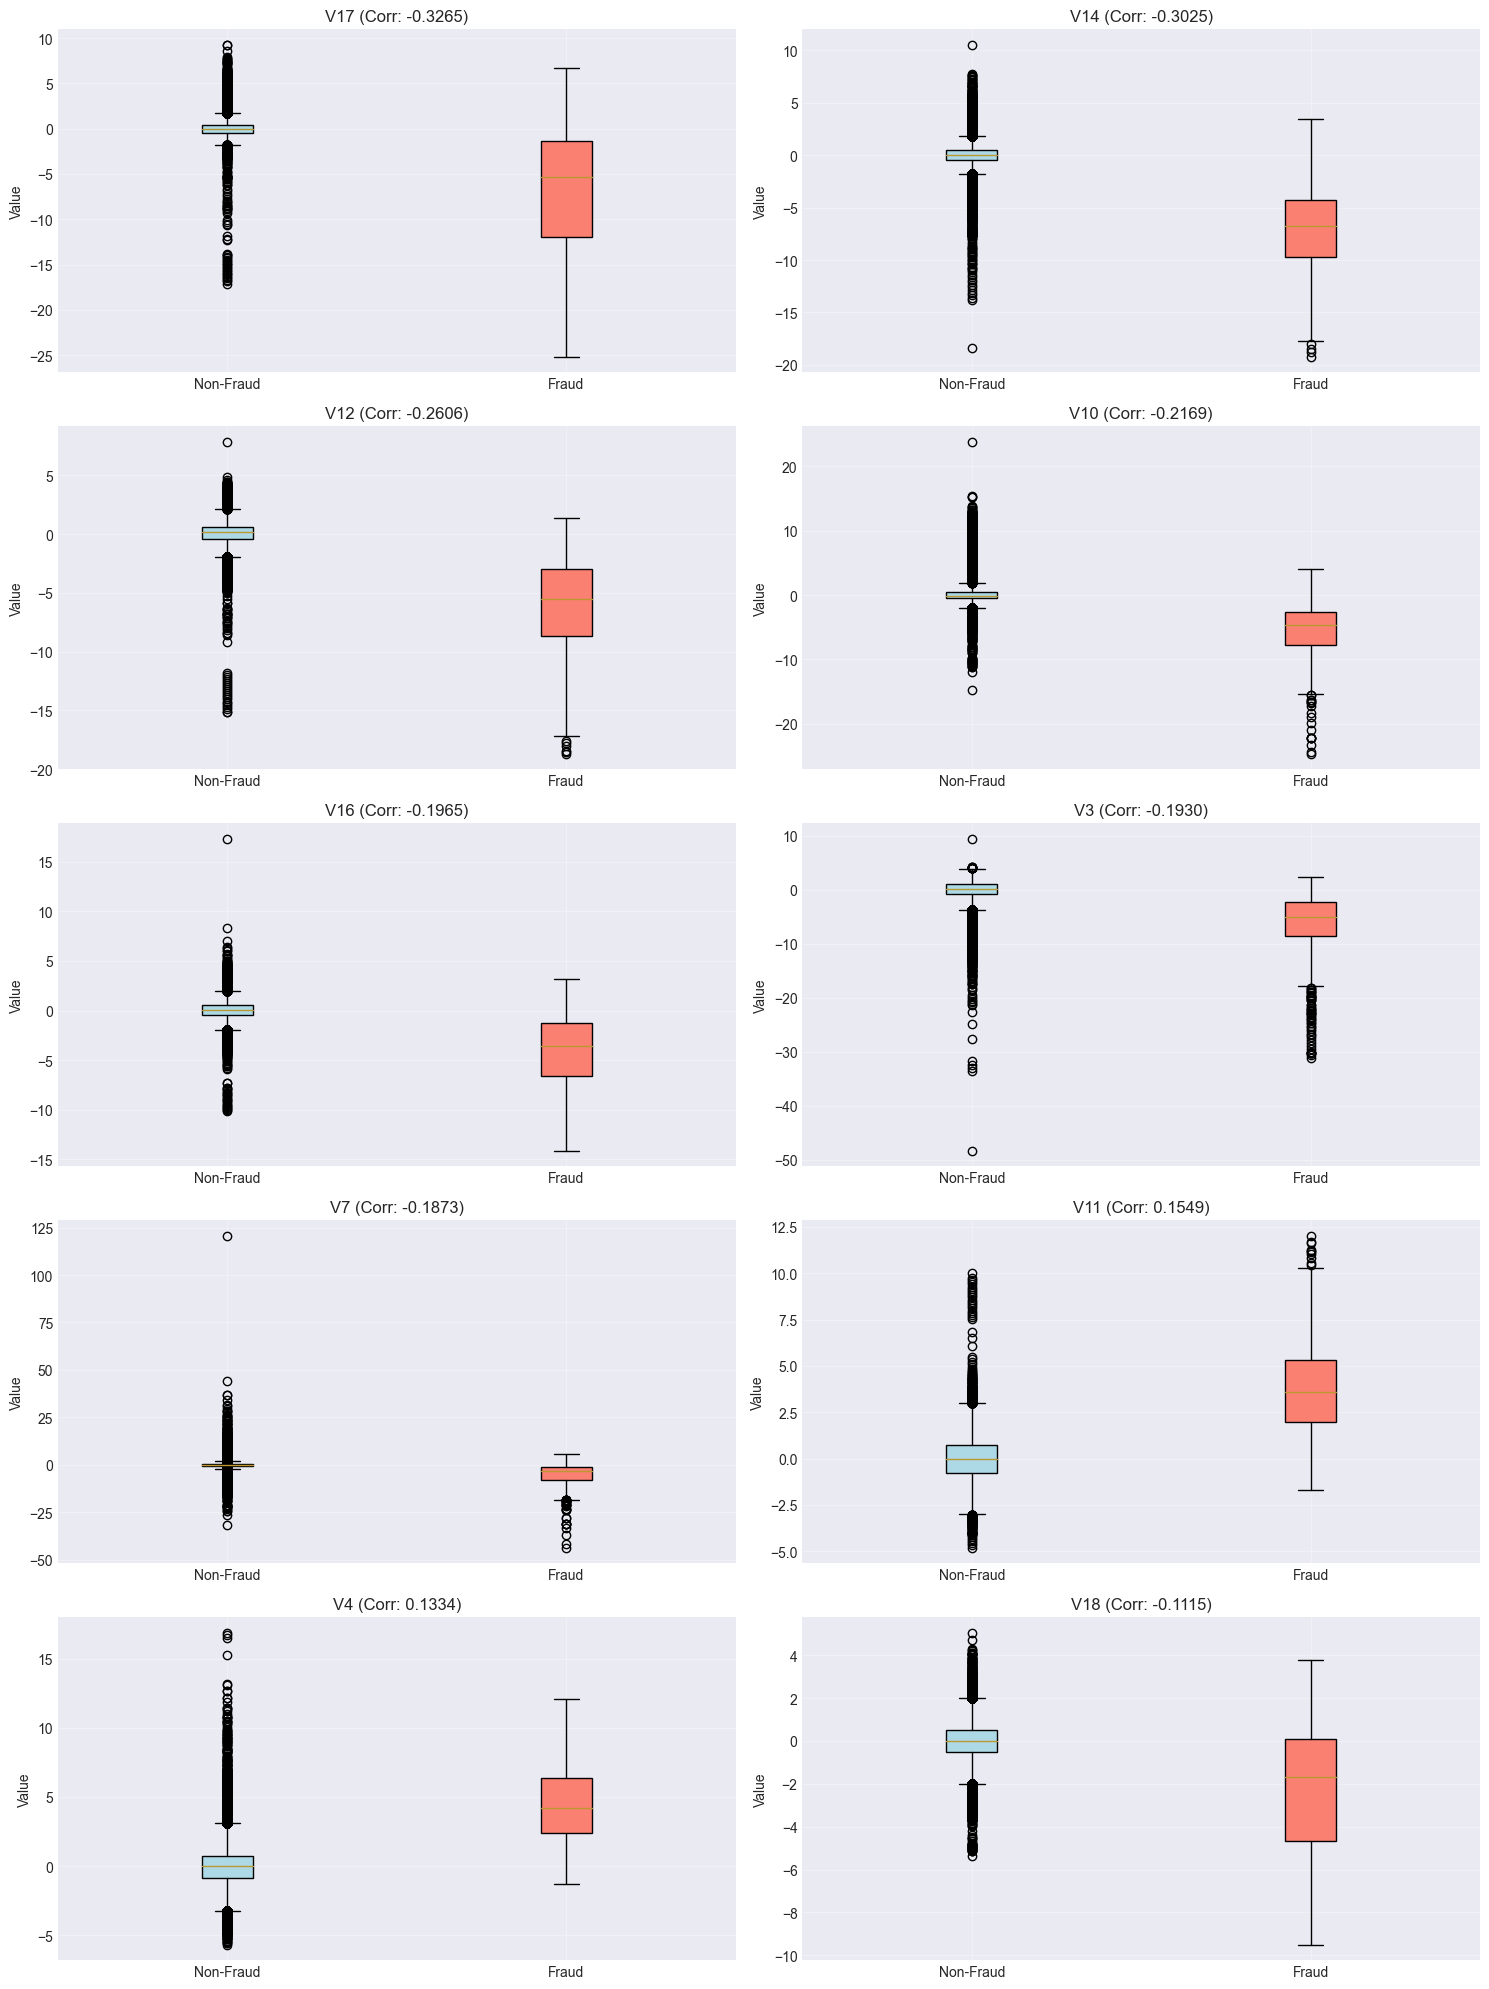

=== Fraud Patterns Over Time ===


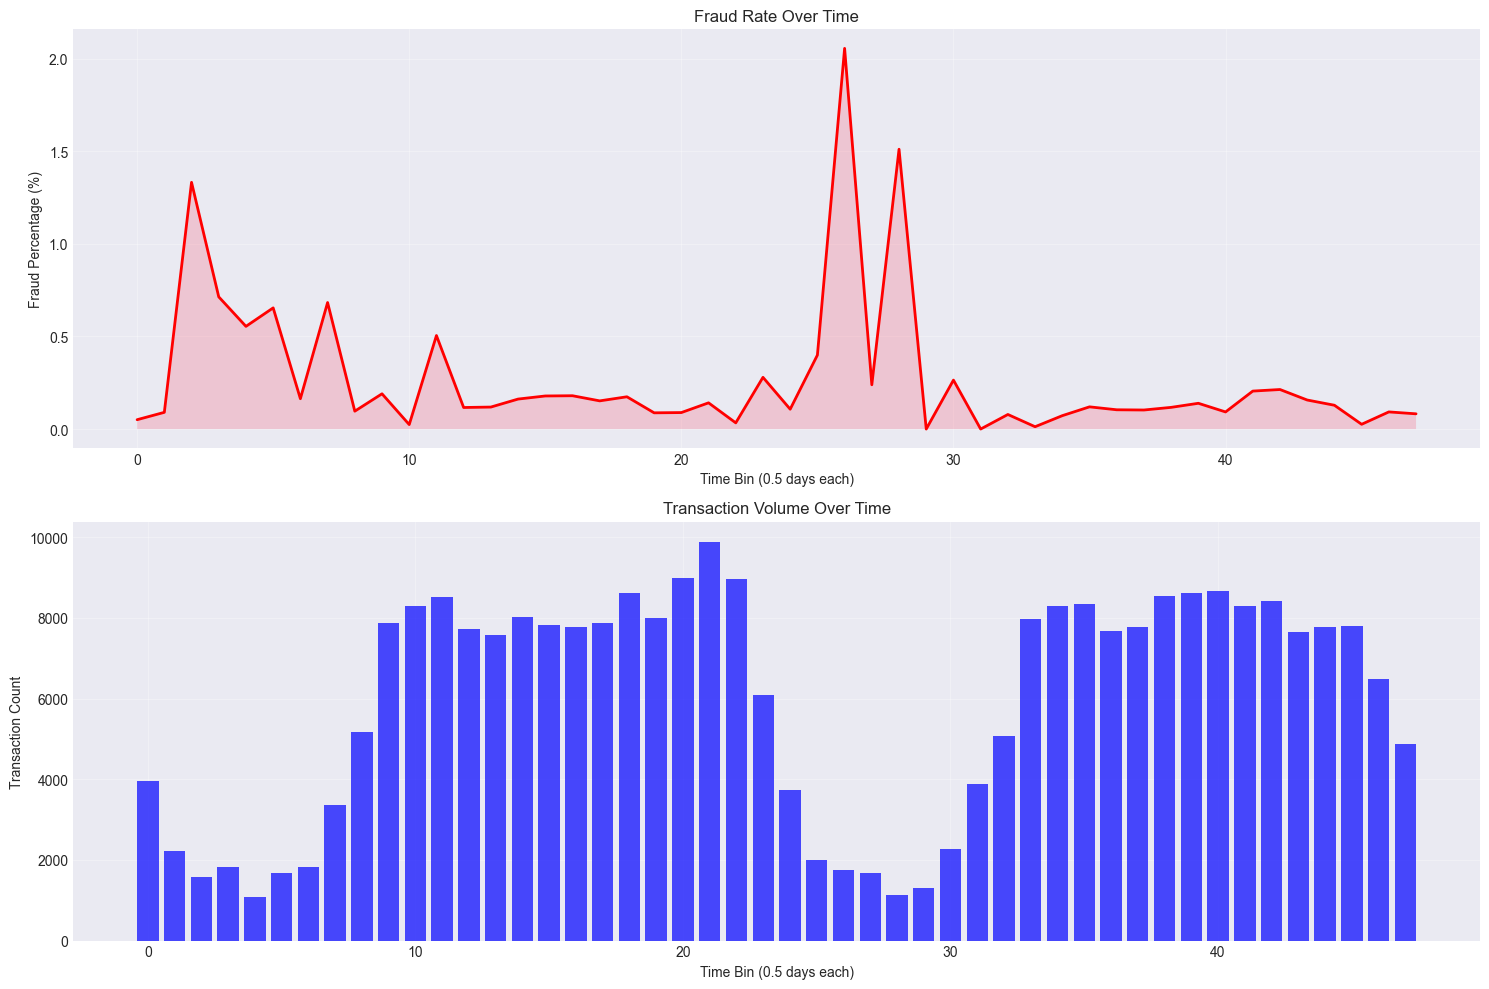

=== Amount vs Fraud Analysis ===


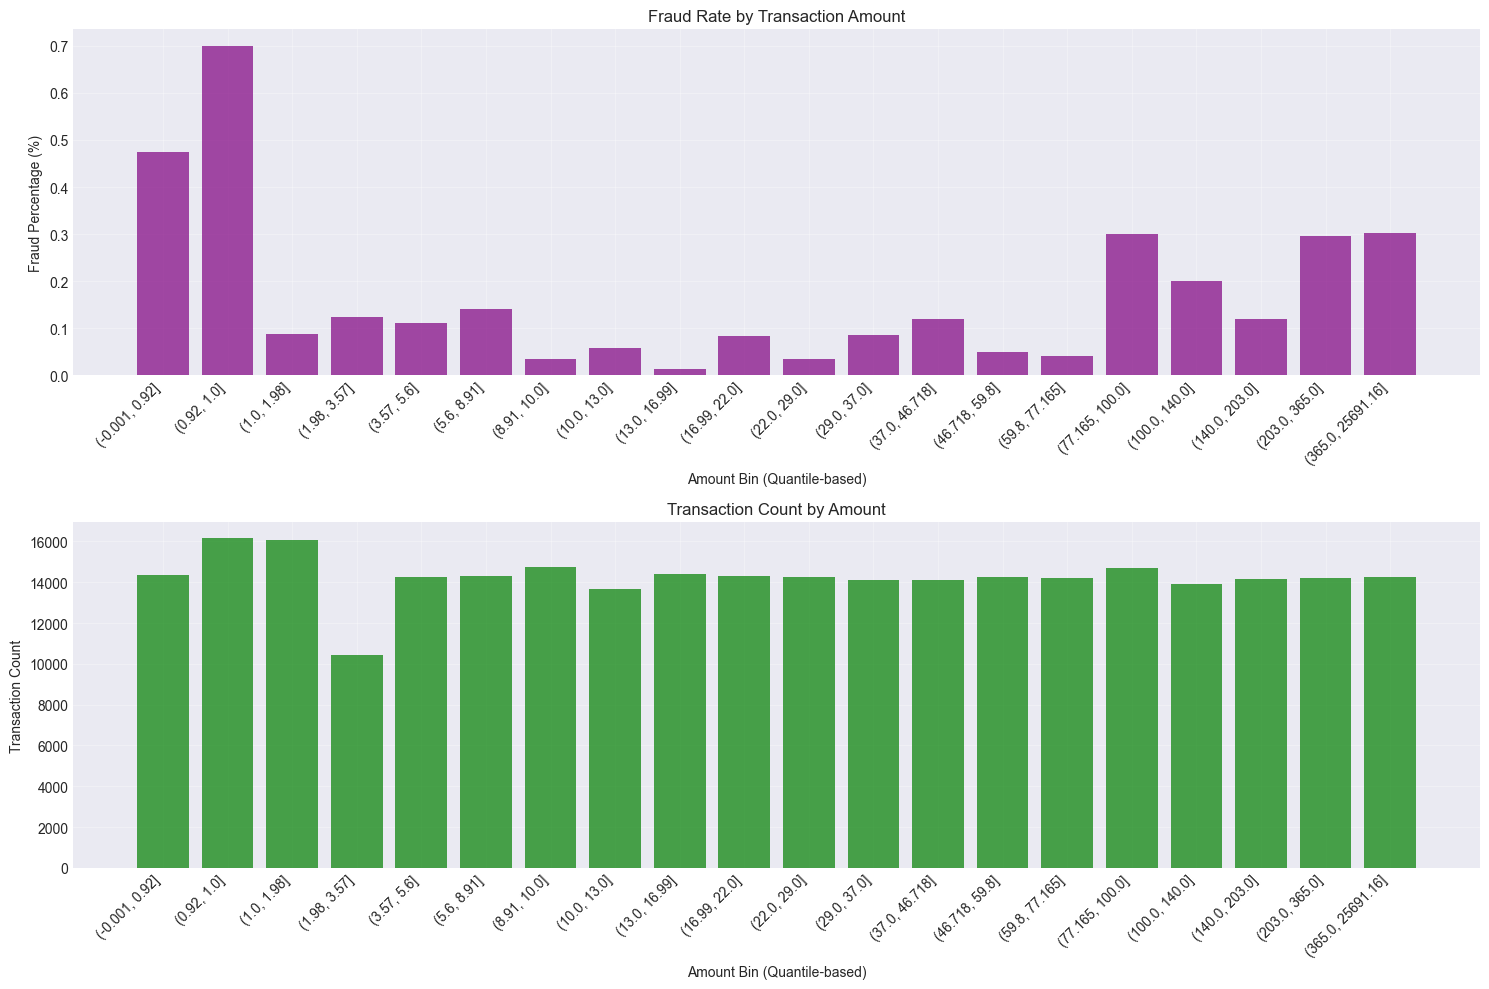

=== Outlier Analysis ===
Average outliers per transaction: 0.28
Max outliers in a transaction: 26

Outlier distribution by class:
          count      mean       std  min  25%  50%   75%   max
Class                                                         
0      284315.0  0.264963  1.034953  0.0  0.0  0.0   0.0  26.0
1         492.0  8.514228  5.919504  0.0  4.0  7.0  13.0  22.0
Cleaned data saved to '../data/processed/credit_data_cleaned.csv'

=== Key Insights ===
1. Extreme Class Imbalance: 0.1727% fraud vs 99.83% non-fraud
2. Average transaction amount: $88.35
3. Maximum transaction amount: $25691.16
4. Dataset spans 48.0 hours (2.0 days)
5. Most correlated feature with fraud: V17 (corr: -0.3265)
6. Total fraud cases: 492
7. Total non-fraud cases: 284,315


In [1]:
# %% [markdown]
# # Credit Card Fraud Data Analysis
# This notebook explores the bank transaction dataset (creditcard.csv)

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# %%
# Load the data
credit_data = pd.read_csv('../data/raw/creditcard.csv')
print("Dataset shape:", credit_data.shape)
print("\nColumns:", credit_data.columns.tolist())
print("\nFirst 5 rows:")
credit_data.head()

# %%
# Basic info
print("=== Dataset Information ===")
print(f"Total records: {len(credit_data):,}")
print(f"Number of features: {credit_data.shape[1]}")
print(f"Memory usage: {credit_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# %%
# Check for missing values
print("=== Missing Values ===")
missing = credit_data.isnull().sum()
missing_percent = (missing / len(credit_data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

# %%
# Check for duplicates
duplicates = credit_data.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# %%
# Target variable analysis
print("=== Target Variable Distribution ===")
class_dist = credit_data['Class'].value_counts()
class_percent = credit_data['Class'].value_counts(normalize=True) * 100

class_df = pd.DataFrame({
    'Count': class_dist,
    'Percentage': class_percent
})
print(class_df)

# %%
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
axes[0].bar(['Non-Fraud (0)', 'Fraud (1)'], class_dist.values, 
            color=['lightblue', 'salmon'])
axes[0].set_title('Class Distribution (Count)')
axes[0].set_ylabel('Count')

# Add count labels
for i, v in enumerate(class_dist.values):
    axes[0].text(i, v + max(class_dist.values)*0.01, 
                f'{v:,}', ha='center', fontweight='bold')

# Pie chart (log scale for better visualization)
axes[1].pie([class_dist[0], class_dist[1]], 
           labels=['Non-Fraud', 'Fraud'], 
           autopct=lambda p: '{:.1f}%\n({:,.0f})'.format(p, p*sum(class_dist.values)/100),
           startangle=90, colors=['lightblue', 'salmon'])
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig('../notebooks/credit_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Time and Amount analysis
print("=== Time and Amount Analysis ===")
print(credit_data[['Time', 'Amount']].describe())

# %%
# Visualize Time and Amount distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time distribution - all transactions
axes[0,0].hist(credit_data['Time'] / 3600, bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_xlabel('Time (hours since first transaction)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Transaction Time')
axes[0,0].axvline(credit_data['Time'].mean() / 3600, color='red', 
                  linestyle='--', label=f'Mean: {credit_data["Time"].mean()/3600:.1f}h')
axes[0,0].legend()

# Amount distribution - all transactions
axes[0,1].hist(credit_data['Amount'], bins=50, edgecolor='black', alpha=0.7, log=True)
axes[0,1].set_xlabel('Transaction Amount ($)')
axes[0,1].set_ylabel('Frequency (log scale)')
axes[0,1].set_title('Distribution of Transaction Amounts (Log Scale)')
axes[0,1].axvline(credit_data['Amount'].mean(), color='red', linestyle='--', 
                  label=f'Mean: ${credit_data["Amount"].mean():.2f}')
axes[0,1].legend()

# Time distribution by class
for class_val in [0, 1]:
    subset = credit_data[credit_data['Class'] == class_val]
    axes[1,0].hist(subset['Time'] / 3600, bins=50, alpha=0.5, 
                   label=f'Class {class_val}', density=True)
axes[1,0].set_xlabel('Time (hours since first transaction)')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Time Distribution by Class (Normalized)')
axes[1,0].legend()

# Amount distribution by class
for class_val in [0, 1]:
    subset = credit_data[credit_data['Class'] == class_val]
    axes[1,1].hist(subset['Amount'], bins=50, alpha=0.5, 
                   label=f'Class {class_val}', density=True, log=True)
axes[1,1].set_xlabel('Transaction Amount ($)')
axes[1,1].set_ylabel('Density (log scale)')
axes[1,1].set_title('Amount Distribution by Class (Normalized, Log Scale)')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../notebooks/time_amount_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# PCA components analysis
print("=== PCA Components Analysis ===")

# Calculate statistics for PCA components
pca_cols = [f'V{i}' for i in range(1, 29)]
pca_stats = pd.DataFrame({
    'Mean': credit_data[pca_cols].mean(),
    'Std': credit_data[pca_cols].std(),
    'Min': credit_data[pca_cols].min(),
    'Max': credit_data[pca_cols].max()
})
print(pca_stats.head(10))

# %%
# Visualize distribution of first few PCA components
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (ax, col) in enumerate(zip(axes[:9], pca_cols[:9])):
    ax.hist(credit_data[col], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.axvline(credit_data[col].mean(), color='red', linestyle='--', alpha=0.7)

# Hide unused subplots
for ax in axes[9:]:
    ax.axis('off')

plt.tight_layout()
plt.savefig('../notebooks/pca_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Correlation analysis
print("=== Correlation with Target ===")

# Calculate correlation with target
correlations = {}
for col in credit_data.columns:
    if col != 'Class' and col != 'Time':
        correlations[col] = credit_data[col].corr(credit_data['Class'])

# Create correlation dataframe
corr_df = pd.DataFrame({
    'Feature': correlations.keys(),
    'Correlation': correlations.values()
}).sort_values('Correlation', key=abs, ascending=False)

print("Top 10 features most correlated with fraud:")
print(corr_df.head(10))

# %%
# Visualize top correlated features
top_features = corr_df.head(10)['Feature'].tolist()

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i, (ax, feature) in enumerate(zip(axes, top_features)):
    # Create boxplot by class
    data_to_plot = []
    for class_val in [0, 1]:
        data_to_plot.append(credit_data[credit_data['Class'] == class_val][feature].values)
    
    bp = ax.boxplot(data_to_plot, labels=['Non-Fraud', 'Fraud'], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'salmon']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{feature} (Corr: {correlations[feature]:.4f})')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/top_correlations_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Fraud patterns over time
print("=== Fraud Patterns Over Time ===")

# Convert time to hours and create bins
credit_data['Time_hours'] = credit_data['Time'] / 3600
credit_data['Time_bin'] = pd.cut(credit_data['Time_hours'], bins=48)  # 48 bins = 0.5 day each

# Calculate fraud rate by time bin
fraud_by_time = credit_data.groupby('Time_bin')['Class'].agg(['mean', 'count'])
fraud_by_time['fraud_percentage'] = fraud_by_time['mean'] * 100

# Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Fraud percentage over time
axes[0].plot(range(len(fraud_by_time)), fraud_by_time['fraud_percentage'], 
             linewidth=2, color='red')
axes[0].fill_between(range(len(fraud_by_time)), fraud_by_time['fraud_percentage'], alpha=0.3)
axes[0].set_xlabel('Time Bin (0.5 days each)')
axes[0].set_ylabel('Fraud Percentage (%)')
axes[0].set_title('Fraud Rate Over Time')
axes[0].grid(True, alpha=0.3)

# Transaction volume over time
axes[1].bar(range(len(fraud_by_time)), fraud_by_time['count'], 
            alpha=0.7, color='blue')
axes[1].set_xlabel('Time Bin (0.5 days each)')
axes[1].set_ylabel('Transaction Count')
axes[1].set_title('Transaction Volume Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/fraud_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Amount vs Fraud analysis
print("=== Amount vs Fraud Analysis ===")

# Create amount bins
credit_data['Amount_bin'] = pd.qcut(credit_data['Amount'], q=20, duplicates='drop')

# Calculate fraud rate by amount bin
fraud_by_amount = credit_data.groupby('Amount_bin')['Class'].agg(['mean', 'count'])
fraud_by_amount['fraud_percentage'] = fraud_by_amount['mean'] * 100

# Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Fraud percentage by amount
axes[0].bar(range(len(fraud_by_amount)), fraud_by_amount['fraud_percentage'], 
            alpha=0.7, color='purple')
axes[0].set_xlabel('Amount Bin (Quantile-based)')
axes[0].set_ylabel('Fraud Percentage (%)')
axes[0].set_title('Fraud Rate by Transaction Amount')
axes[0].set_xticks(range(len(fraud_by_amount)))
axes[0].set_xticklabels([str(bin_) for bin_ in fraud_by_amount.index], 
                       rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# Transaction count by amount
axes[1].bar(range(len(fraud_by_amount)), fraud_by_amount['count'], 
            alpha=0.7, color='green')
axes[1].set_xlabel('Amount Bin (Quantile-based)')
axes[1].set_ylabel('Transaction Count')
axes[1].set_title('Transaction Count by Amount')
axes[1].set_xticks(range(len(fraud_by_amount)))
axes[1].set_xticklabels([str(bin_) for bin_ in fraud_by_amount.index], 
                       rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/fraud_by_amount.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Outlier detection in PCA components
print("=== Outlier Analysis ===")

# Calculate z-scores for PCA components
z_scores = np.abs(stats.zscore(credit_data[pca_cols]))
outliers = (z_scores > 3).sum(axis=1)
credit_data['outlier_count'] = outliers

print(f"Average outliers per transaction: {outliers.mean():.2f}")
print(f"Max outliers in a transaction: {outliers.max()}")
print(f"\nOutlier distribution by class:")
print(credit_data.groupby('Class')['outlier_count'].describe())

# %%
# Save processed data
credit_data.to_csv('../data/processed/credit_data_cleaned.csv', index=False)
print("Cleaned data saved to '../data/processed/credit_data_cleaned.csv'")

# %%
# Summary statistics
print("\n=== Key Insights ===")
print(f"1. Extreme Class Imbalance: {class_percent[1]:.4f}% fraud vs {class_percent[0]:.2f}% non-fraud")
print(f"2. Average transaction amount: ${credit_data['Amount'].mean():.2f}")
print(f"3. Maximum transaction amount: ${credit_data['Amount'].max():.2f}")
print(f"4. Dataset spans {credit_data['Time'].max()/3600:.1f} hours ({credit_data['Time'].max()/3600/24:.1f} days)")
print(f"5. Most correlated feature with fraud: {corr_df.iloc[0]['Feature']} (corr: {corr_df.iloc[0]['Correlation']:.4f})")
print(f"6. Total fraud cases: {class_dist[1]:,}")
print(f"7. Total non-fraud cases: {class_dist[0]:,}")